# Plots for "Urban highways are barriers for social ties"

Running this notebook will reproduce all major plots from the research paper [Urban highways are barriers for social ties](https://arxiv.org/abs/2404.11596). Whereever privacy concerns did not prohibit it, we provide real (aggregated) data (cf. `./data/realdata/`).

In [1]:
# read in libraries (Python)
import warnings
warnings.filterwarnings('ignore')

import pickle
import pandas as pd
import geopandas as gpd

import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from PIL import Image

import osmnx as ox
from shapely.geometry import Point
from shapely.ops import transform
import pyproj
from pyproj.crs import ProjectedCRS
from pyproj.crs.coordinate_operation import AzimuthalEquidistantConversion

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
import seaborn as sns

In [2]:
# define colors
c_blue = '#0081AF' 
c_lightblue = '#00AFB9'
c_red = '#A30000'
c_black = '#050609'
c_gray = '#555555'
c_green = '#509B8F'
#c_green = '#2a9d8f'
c_purple = '#6F1473'
c_orange = '#FDAF00'
c_peach = '#FED9B7'
c_yellow = '#FFBE0B'
c_lightyellow = '#FDFCDC'
c_gray = '#555555'


In [3]:
# define helper functions
def geodesic_point_buffer(lon, lat, meters):
    proj_crs = ProjectedCRS(conversion = AzimuthalEquidistantConversion(lat, lon))
    proj_wgs84 = pyproj.Proj('EPSG:4326')
    Trans = pyproj.Transformer.from_proj(proj_crs, proj_wgs84, always_xy=True).transform
    return transform(Trans, Point(0, 0).buffer(meters))

In [4]:
# define helper variables
data_path = '../data/realdata'
df_cbsacodes = pd.read_csv(f'../data/cbsacode.csv')
df_cbsacodes = df_cbsacodes.sort_values(by='num_users', ascending=False)
cbsacodes = df_cbsacodes.sort_values(by='num_users', ascending=False)['cbsacode']
city_names = df_cbsacodes.sort_values(by='num_users', ascending=False)['name']
city_names_full = df_cbsacodes.sort_values(by='num_users', ascending=False)['full_name']
cbsacode2name = {code:name for code,name in zip(cbsacodes,city_names)}
cbsacode2name_full = {code:name for code,name in zip(cbsacodes,city_names_full)}

## Gravity model

In [5]:
df_gravity = pd.read_csv(f'{data_path}/results_gravity.csv')
d = df_gravity.groupby('cell_width_gravity').mean(numeric_only=True).reset_index()

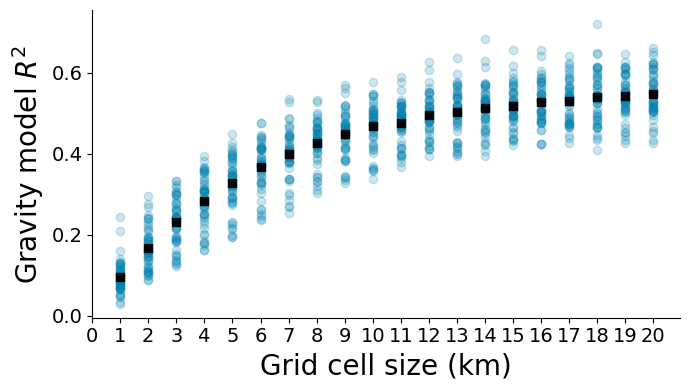

In [6]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.scatter(df_gravity['cell_width_gravity'], df_gravity['r2'], alpha=0.2, color=c_blue)
ax.scatter(d['cell_width_gravity'], d['r2'], marker='s', alpha=1, color=c_black)
ax.set_xlabel('Grid cell size (km)', fontsize=20)
ax.set_ylabel('Gravity model $R^2$', fontsize=20)
ax.set_xticks(range(0,21000,1000))
ax.set_xticklabels(range(0,21,1))
ax.tick_params(axis='both', which='both', labelsize=14)
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
fig.savefig(
    "../plots/gravitymodel.png", 
    dpi = 300, 
    bbox_inches = "tight"
)
plt.show()

## Beeline vs Walking correlation

In [7]:
df_beeline = pd.read_csv(f'{data_path}/results_beeline_walking_corr.csv')
df_beeline.head(3)

,cbsacode,cityname,pearson_r,pearson_pval,spearman_r,spearman_pval
0,35620,NewYork,0.991067,0.0,0.989805,0.0
1,31080,LosAngeles,0.997693,0.0,0.997256,0.0
2,16980,Chicago,0.996244,0.0,0.995884,0.0


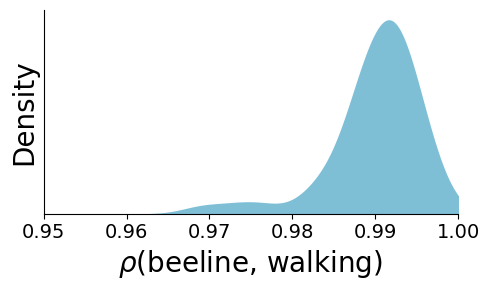

In [8]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
sns.kdeplot(data=df_beeline, x="pearson_r", fill=True, common_norm=False, 
            palette="crest", alpha=.5, linewidth=0, ax=ax, color=c_blue)

ax.set_xlabel(r'$\rho$(beeline, walking)', fontsize=20)
ax.set_ylabel('Density', fontsize=20)
ax.set_xlim([0.95,1])
ax.set_yticks([])
#ax.set_xticks([0,5000,10000,15000,20000])
ax.tick_params(axis='both', which='both', labelsize=14)
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
fig.savefig(
    "../plots/beeline-walking-corr.png", 
    dpi = 300, 
    bbox_inches = "tight"
)
plt.show()

## Errors in null model

In [9]:
df_dists = pd.read_csv(f'{data_path}/results_length_social_links.csv')
df_err = pd.read_csv(f'{data_path}/results_error.csv')

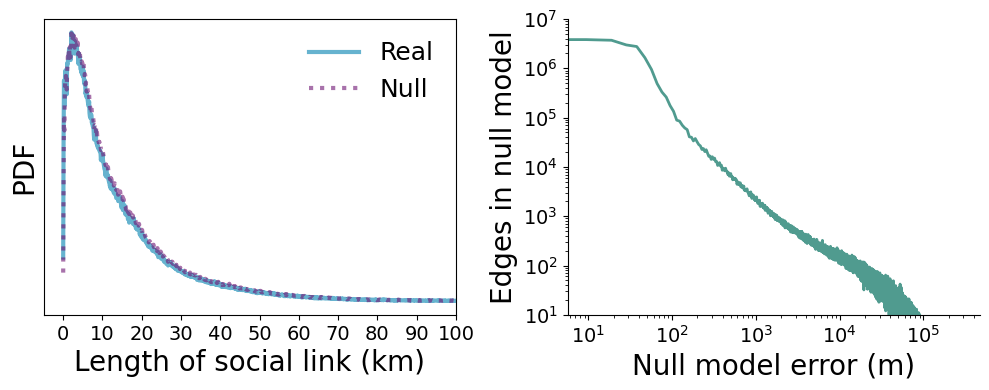

In [10]:
# plot distances and errors together
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1, ax2, = axs
ax1.plot(df_dists['d'], df_dists['real'], color=c_blue, alpha=0.6, linewidth=3, label='Real')
ax1.plot(df_dists['d'], df_dists['null'], ':' ,color=c_purple, alpha=0.6, linewidth=3, label='Null')
ax1.set_yticklabels([])
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.legend(fontsize=18, frameon=False)
ax1.set_xlim(-5000,100000)
ax1.set_ylabel('PDF', fontsize=20)
ax1.set_xlabel('Length of social link (km)', fontsize=20)
ax1.set_yticklabels([])
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.legend(fontsize=18, frameon=False)
ax1.set_xlim(-5000,100000)
ax1.set_xticks(range(0,100001,10000))
ax1.set_xticklabels(range(0,101,10))
ax1.set_yticks([])

ax2.plot(df_err['error'], df_err['num_edges'], color=c_green, alpha=1, linewidth=2)
ax2.set_yticks([0,100,1000,10000,1000000])
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylabel('Edges in null model', fontsize=20)
ax2.set_xlabel('Null model error (m)', fontsize=20)
ax2.tick_params(axis='both', which='both', labelsize=14)
ax2.set_ylim([10,10000000])

ax2.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
fig.savefig(
    "../plots/errors-nullmodel.png", 
    dpi = 300, 
    bbox_inches = "tight"
)
plt.show()

## Random street layout

In [11]:
df = pd.read_csv(f'{data_path}/results_randstreet.csv')
df.head(2)

,cbsacode,city_name,distance_binned,barrier_score,ci_low,ci_high,barrier_score_randstreet,ci_low_randstreet,ci_high_randstreet
0,19100,Dallas,0,1.176025,1.218638,1.133413,1.049030,1.066576,1.031485
1,19100,Dallas,500,1.167565,1.199941,1.135190,1.039891,1.053715,1.026067


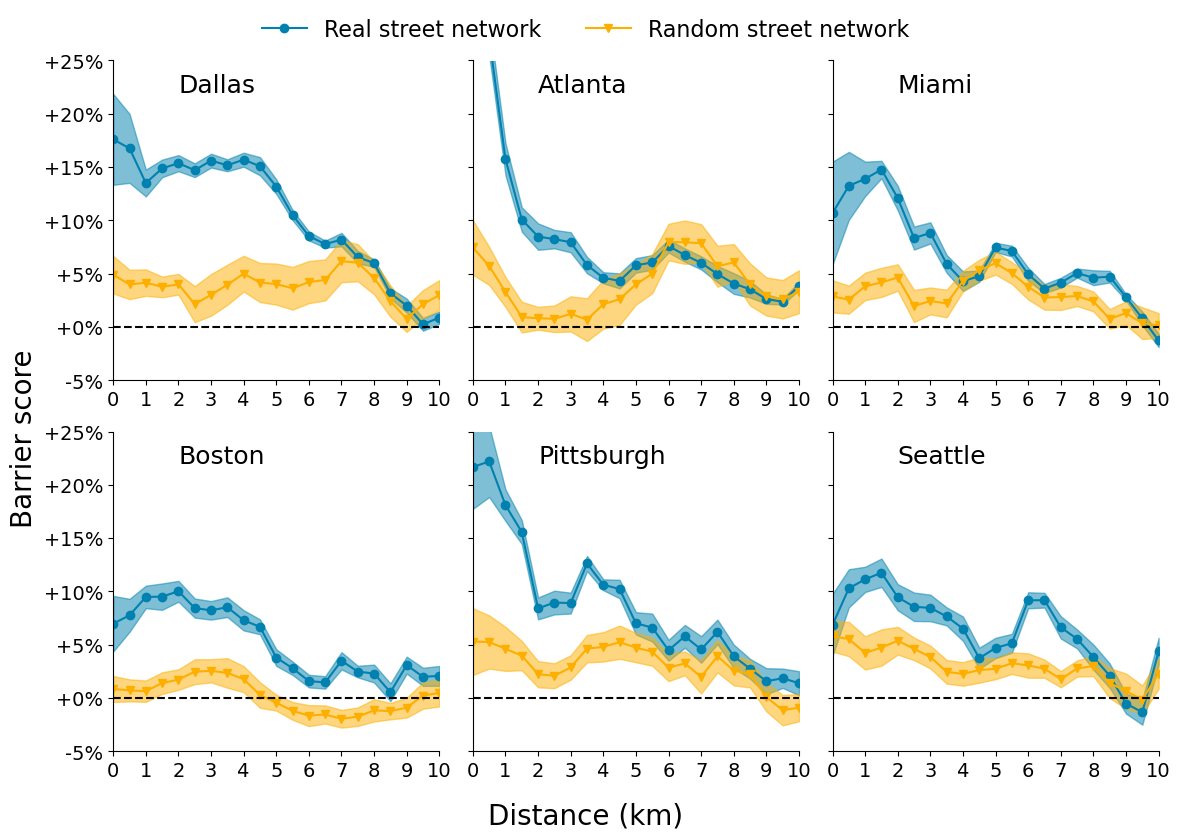

In [12]:
maxlength_m = 10000
distance_type = 'beeline'
smoothing = '_smooth' # '' '_smooth'

row=0
col=-1
nrows=2
ncolumns=3
fig, axs = plt.subplots(nrows, ncolumns, figsize=(12,8))

for cbsacode in [19100, 12060, 33100, 14460, 38300, 42660]:
    city_name = cbsacode2name[cbsacode]
    df_city = df[df['cbsacode'] == cbsacode]
    if col<ncolumns-1:
        col = col+1
    else:
        col=0
        row = row+1
    ax=axs[row][col]
    ax.set_yticklabels(['-5%', '+0%', '+5%', '+10%', '+15%', '+20%', '+25%'])
    if col > 0:
        ax.set_yticklabels([])
    ax.set_xlim(0,maxlength_m)
    ax.set_xticks(range(0,11000,1000))
    ax.set_xticklabels(range(0,11,1))
    #ax.set_ylim([0.75,1.05])
    ax.set_ylim([0.95,1.25])
    lines_real = ax.plot(df_city['distance_binned'], df_city['barrier_score'], '-o', c=c_blue, label='Real street network')
    ax.fill_between(df_city['distance_binned'], df_city['ci_low'],df_city['ci_high'], color=c_blue, alpha=0.5)
    
    lines_random = ax.plot(df_city['distance_binned'], df_city['barrier_score_randstreet'], '-v', c=c_orange, label=f'Random street network')
    ax.fill_between(df_city['distance_binned'], df_city['ci_low_randstreet'],df_city['ci_high_randstreet'], color=c_orange, alpha=0.5)
    
    ax.plot((0,maxlength_m), (1,1), '--', c='black')
    ax.text(2000,1.22,city_name,fontsize=18)
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='both', labelsize=14)
        
plt.figlegend(lines_real+lines_random, ['Real street network', 'Random street network'], 
              loc = 'upper center', ncol=2, frameon=False,  fontsize=16, labelspacing=0.,
              bbox_to_anchor=(0.5, 1.05))

# common labels
fig.supxlabel('Distance (km)', fontsize=20)
fig.supylabel('Barrier score', fontsize=20)
plt.tight_layout()
fig.savefig(
    "../plots/randomstreetlayout.png", 
    dpi = 300, 
    bbox_inches = "tight"
)
plt.show()

## Regression table

In [13]:
df_regr = pd.read_csv(f'{data_path}/results_regression_alldist.csv')
df_regr.head(4)

,cbsacode,city_name,distance,log_streetlength_motorway,log_RDID,pop_density_metro,barrier_score
0,12060,Atlanta,1000,12.496347,-0.039074,20.258139,0.246044
1,12420,Austin,1000,13.036651,-0.106999,84.091281,0.006876
2,12580,Baltimore,1000,13.024219,-0.162315,77.351471,0.128755
3,13820,Birmingham,1000,12.658786,-0.135911,18.192537,0.062941


In [14]:
y_var = 'barrier_score'
xvars = ['log_streetlength_motorway', 'log_RDID', 'pop_density_metro']
    
r2_adj_list = []
coeff_list = []
pval_list = []
sensitivity_plot_only = False # this one produces results only for the plot
for rng in range(1000,50001,1000):
    df_city = df_regr[df_regr['distance']==rng]
    
    X = df_city[xvars].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    Y = df_city[y_var].values
    Y = Y.reshape((-1,1))
    Y = scaler.fit_transform(Y)
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    if rng == 10000:
        results_10k = results
    r2_adj = results.rsquared_adj
    coefficients = results.params[1:]
    pvals = results.pvalues[1:]
    
    r2_adj_list.append(r2_adj)
    coeff_list.append(coefficients)
    pval_list.append(pvals)
    
    # print(f'========= <{rng}m')
    # print(f'***OLS REGRESSION (N={len(Y)}, R2_adj = {r2_adj:.3f})')
    # for beta,p,var in zip(coefficients, pvals, ['const']+xvars):
    #     print(f'{var}: {beta:.3f} (p={p:.3f})')
        
results_10k.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     5.908
Date:                Fri, 03 May 2024   Prob (F-statistic):            0.00169
Time:                        18:06:39   Log-Likelihood:                -62.799
No. Observations:                  50   AIC:                             133.6
Df Residuals:                      46   BIC:                             141.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.533e-16      0.125  -2.02e-15      1.000      -0.252       0.252
x1             0.4689      0.139      3.372      0.002       0.189       0.749
x2            -0.2573      0.129     -2.001      0.051      -0.516       0.001
x3            -0.3902      0.139     -2.802      0.007      -0.670      -0.110
==============================================================================
Omnibus:                        6.210   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                5.392
Skew:                           0.789   Prob(JB):                       0.0675
Kurtosis:                       3.312   Cond. No.                         1.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

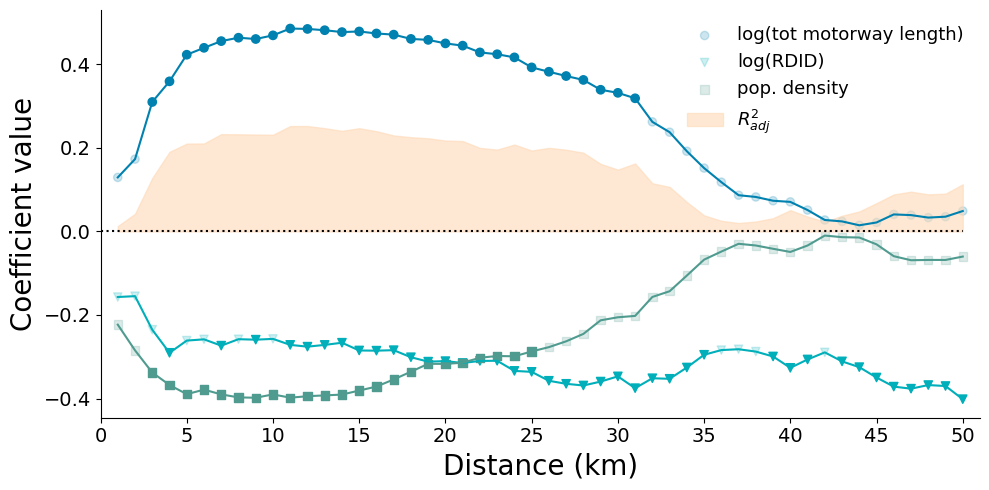

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

coeffs = list(zip(*coeff_list))
pvals = list(zip(*pval_list))
labels = ['log(tot motorway length)', 'log(RDID)', 'pop. density']
colors = [c_blue, c_lightblue, c_green]
markers = ['o','v','s']
for b,p,l,c,m in zip(coeffs,pvals,labels,colors,markers):
    p = [1 if _<=0.05 else 0.2 for _ in p ]
    ax.plot(range(1000,50001,1000),b,'-',color=c)
    ax.scatter(range(1000,50001,1000),b,marker=m,label=l,alpha=p,color=c)
ax.fill_between(
    range(1000,50001,1000), 
    r2_adj_list, 
    label='$R^2_{adj}$',
    alpha=0.6, 
    color=c_peach
)
ax.plot([0,50000],[0,0],':',c='#000000')
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_xticks(range(0,51000,5000))
ax.set_xticklabels(range(0,51,5))
ax.set_xlabel('Distance (km)', fontsize=20)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim([0,51000])
ax.set_ylabel('Coefficient value', fontsize=20)
leg = ax.legend(fontsize=13, frameon=False)
plt.tight_layout()
fig.savefig(
    "../plots/regression.png", 
    dpi = 300, 
    bbox_inches = "tight"
)
plt.show()

## Heatmap

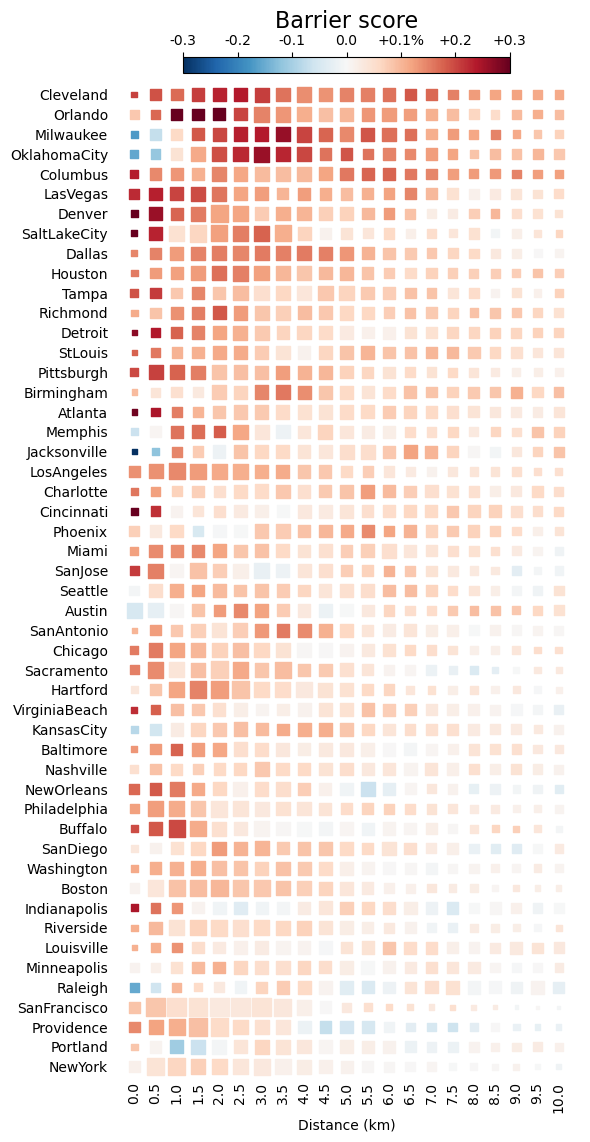

In [16]:
df_all = pd.read_csv(f'{data_path}/results_heatmap.csv')

# scatterplot
fig, ax = plt.subplots(1,1, figsize=(6,12))
y_var = 'barrier_score'
# color matrix
cmap = cm.RdBu_r#cm.coolwarm_r
twoslopenorm = mcolors.TwoSlopeNorm(vmin=0.70, vcenter=1, vmax=1.3001)
scatter_x = df_all['distance_binned']/500
scatter_y = 50-df_all['city_rank']
scatter_c = df_all['barrier_score']
scatter_s = (df_all['count_real_normalized']*170)**2
scatter_s = [max(min(x, 180), 0) for x in scatter_s] # putting a cap to size to avoid overlaps
im = ax.scatter(scatter_x, scatter_y, s=scatter_s, c=scatter_c,
                cmap=cmap, norm=twoslopenorm, marker='s')

cbar = fig.colorbar(im, ax=ax, fraction=0.1, shrink=0.7, pad=0.01, orientation="horizontal", anchor=(0.5,0.0), location='top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('top')
#    cbar.set_ticklabels(['-30%', '-20%', '-10%', '0%', '+10%', '+20%', '+30%'])
cbar.set_ticklabels(['-0.3', '-0.2', '-0.1', '0.0', '+0.1%', '+0.2', '+0.3'])
cbar.set_label(f'Barrier score', fontsize=16, rotation=0)
#     cax.set_axis_off()

# ticks and labels
y_labels = list(df_all[['city_name','city_rank']].drop_duplicates().sort_values(by='city_rank',ascending=False)['city_name'])
ax.spines[['right', 'top','left','bottom']].set_visible(False)
ax.set_yticks(range(1,51))
ax.set_yticklabels(y_labels)
ax.set_xticks(range(0,21))
ax.set_xticklabels(df_all['distance_binned'].drop_duplicates().sort_values()/1000,rotation=90)
ax.set_ylabel('')
ax.set_ylim(0.5,50+0.5)
ax.set_xlabel('Distance (km)')
ax.tick_params('both', length=0)
plt.tight_layout()
fig.savefig(
    "../plots/heatmap.png", 
    dpi = 300, 
    bbox_inches = "tight"
)
plt.show()

## Comparison motorway with other street types

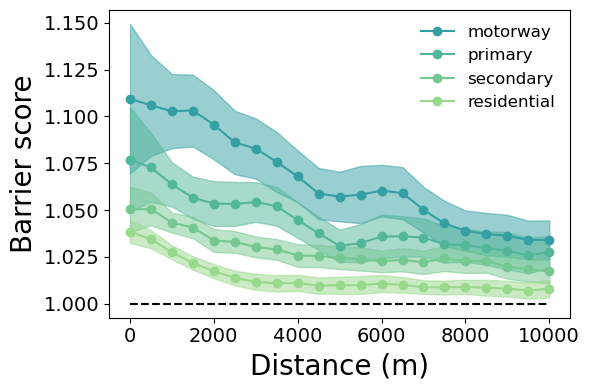

In [17]:
df_streettypes = pd.read_csv(f'{data_path}/results_streettypes.csv')

fig, ax = plt.subplots(1,1, figsize=(6,4))

street_types = ['motorway', 'primary', 'secondary', 'residential'] #, motorway 'primary', 'secondary', 'residential', 'cycleway']
labels = ['motorway', 'primary', 'secondary', 'residential']
colors = ['#34a0a4', '#52b69a', '#76c893', '#99d98c']
for street_type, c, l in zip(street_types, colors, labels):
    
    X = df_streettypes[df_streettypes['street_type'] == street_type]
    y_var = f'barrier_score'

    ax.plot(X['distance_binned'], X[y_var], '-o', c=c, label=l)
    ax.fill_between(X['distance_binned'], X[f'ci_low'],X[f'ci_high'], color=c, alpha=0.5)
ax.plot((0,10000), (1,1), '--', c='black')

leg = ax.legend(fontsize=12, frameon=False)
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_ylabel('Barrier score', fontsize=20)    
ax.set_xlabel('Distance (m)', fontsize=20)
plt.tight_layout()
fig.savefig(
    "../plots/streettypecomparison.png", 
    dpi = 300, 
    bbox_inches = "tight"
)
plt.show()